# CIFAR-10 Exploratory Data Analysis

## Imports and Loading Dataset

In [44]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This cell needs to be run just once to download the data
transform = transforms.Compose([transforms.ToTensor()])

# Files are downloaded to data directory within local repo
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Check dataset info and class imbalances

### Section takeaways

Based on the code presented in this section it is clear that the CIFAR-10 is composed of 60_000 images, divided into 10 datasets. In the cell below, the dataset was split into train and test subsets with 50_000 and 10_000 images, respetively. The classes are perfectly balanced, each containing 5_000 images. As such, no dataset augmentation techniques were deemed necessary.
A visual inspection of the images was then performed using a function created to display 10 random images and their associated label. Running this cell a few times allows for a better understanding of the dataset and do a first inspection for imbalances in image colors, shape, orientation and other features. This, of course, does not replace further more extensive examination.

For that we start by iterating through the `train_set`, flattening the multidimensional tensor with each of the images pixel intensity and concatenating this info for all 50_000 images in the set. This yields a histogram of pixel intensity distribution, showing a relatively normal distribution centered around 0.4.

We then plotted the RGB variance for each class. In theory, if RGB variance for a given class was very low it means that there is little color variation between the images. This could indicate the presence of a large number of similar colored objects (e.g. all planes being white or all cats being black) which could present an overfitting problem further down the line. This was actually the case. However, given the fact that this is known to be a balanced dataset, the low variance values could also be justified by similarities in the surrounding enviroment of the object in each image (e.g. all deers were photographed in the forest so all images in that class have a color distribution skewed to green).

In [6]:
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")
print(f"Classes: {train_set.classes}")

Train samples: 50000, Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [43]:
def filter_class(dataset, class_idx):
    number_objects = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return number_objects


for idx in range(0, len(train_set.classes)):
    objects_inclass = filter_class(train_set, class_idx=idx)  # Select class with index=idx
    print(f"Number of samples in '{train_set.classes[idx]}' class: {len(objects_inclass)}")

Number of samples in 'airplane' class: 5000
Number of samples in 'automobile' class: 5000
Number of samples in 'bird' class: 5000
Number of samples in 'cat' class: 5000
Number of samples in 'deer' class: 5000
Number of samples in 'dog' class: 5000
Number of samples in 'frog' class: 5000
Number of samples in 'horse' class: 5000
Number of samples in 'ship' class: 5000
Number of samples in 'truck' class: 5000


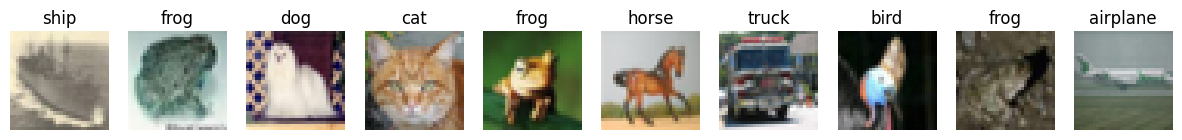

In [22]:
def show_images(dataset, classes, num=10):
    fig, axes = plt.subplots(1, num, figsize=(15, 3))
    for i in range(num):
        img, label = dataset[np.random.randint(len(dataset))]
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(classes[label])
        axes[i].axis('off')
    plt.show()

show_images(train_set, train_set.classes)

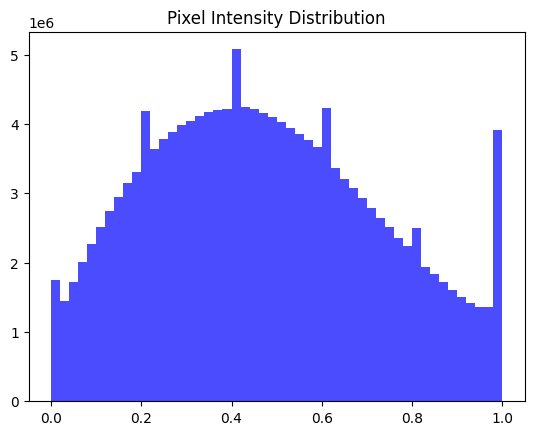

In [39]:
def pixel_intensity_distribution(dataset):
    data = torch.cat([d[0].flatten() for d in dataset])
    plt.hist(data, bins=50, alpha=0.7, color='blue')
    plt.title("Pixel Intensity Distribution")
    plt.show()

pixel_intensity_distribution(train_set)

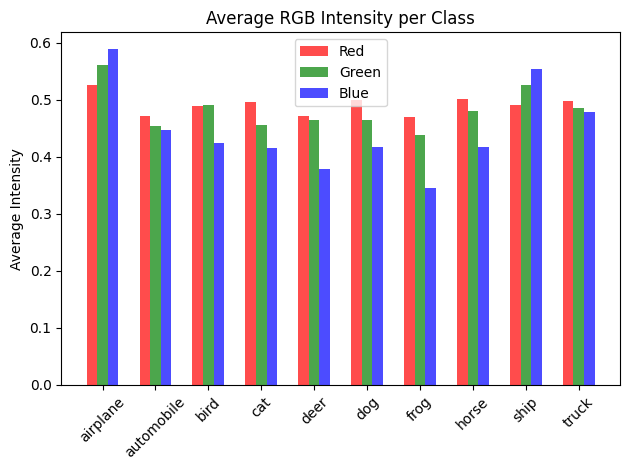

In [41]:
def compute_color_distribution(dataset, num_classes=10):
    avg_colors = torch.zeros((num_classes, 3))  # Store average RGB for each class
    counts = torch.zeros(num_classes)  # Store the number of images in each class

    # Loop through the dataset
    for img, label in dataset:
        avg_colors[label] += img.view(3, -1).mean(dim=1)  # Compute mean RGB
        counts[label] += 1

    avg_colors /= counts.unsqueeze(1)  # Normalize by the number of images per class
    return avg_colors.numpy()

# Compute the average RGB per class
avg_colors = compute_color_distribution(train_set)

# Plot the results
class_names = train_set.classes
x = np.arange(10)
plt.bar(x - 0.2, avg_colors[:, 0], width=0.2, label='Red', color='red', alpha=0.7)
plt.bar(x, avg_colors[:, 1], width=0.2, label='Green', color='green', alpha=0.7)
plt.bar(x + 0.2, avg_colors[:, 2], width=0.2, label='Blue', color='blue', alpha=0.7)
plt.xticks(x, class_names, rotation=45)
plt.ylabel('Average Intensity')
plt.title('Average RGB Intensity per Class')
plt.legend()
plt.tight_layout()
plt.show()

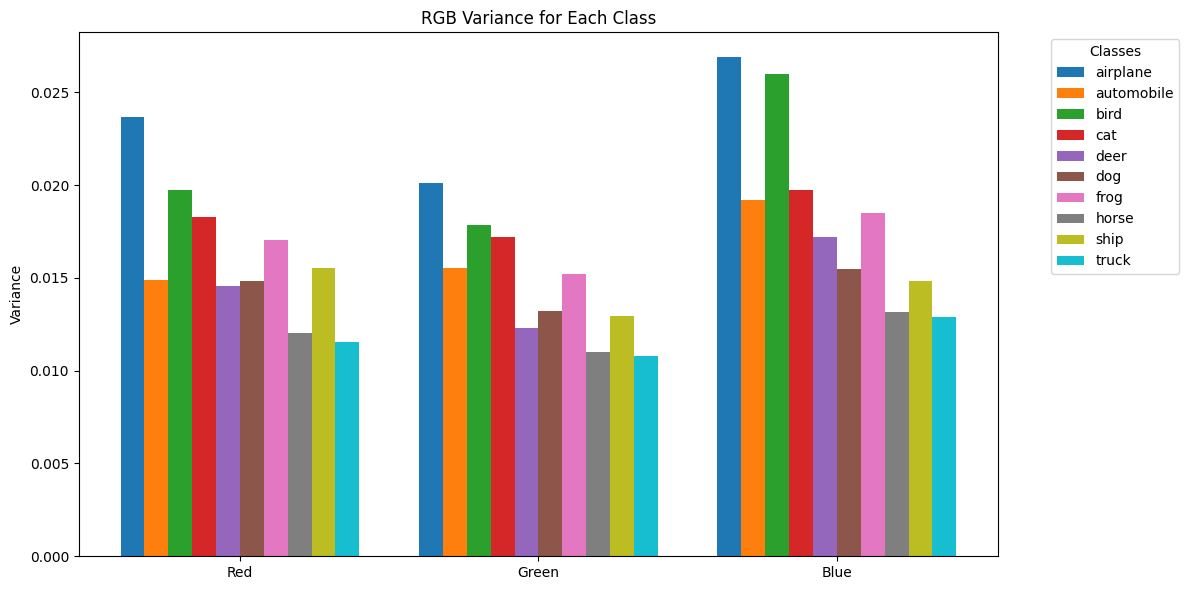

In [48]:
def filter_class_subset(dataset, class_idx):
    indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]
    return Subset(dataset, indices)

def compute_class_color_variance(dataset, class_idx):
    class_subset = filter_class_subset(dataset, class_idx)
    mean_colors = []

    for img, _ in class_subset:
        mean_color = img.view(3, -1).mean(dim=1).numpy()
        mean_colors.append(mean_color)

    mean_colors = np.array(mean_colors)
    variance = np.var(mean_colors, axis=0)
    return variance

variances = []

for idx in range(0, len(train_set.classes)):
    variance = compute_class_color_variance(train_set, class_idx=idx)
    # print(f"Variance in class '{train_set.classes[idx]}' is {variance}")
    variances.append(variance)

variances = np.array(variances)

rgb_channels = ['Red', 'Green', 'Blue']

x = np.arange(len(rgb_channels))
width = 0.08  # Width of each bar
fig, ax = plt.subplots(figsize=(12, 6))

for i, class_name in enumerate(train_set.classes):
    ax.bar(x + i * width, variances[i], width, label=class_name)

ax.set_xticks(x + (len(train_set.classes) * width) / 2 - width / 2)
ax.set_xticklabels(rgb_channels)
ax.set_ylabel('Variance')
ax.set_title('RGB Variance for Each Class')
ax.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()